In [ ]:
#Kickstarter machine learning project.

##Section one: Busniess goal



The goal of this project is to predict whether a Kickstarter project will be successful or fail at the time of launch, using information that is available before the campaign begins.

This prediction can help creators, investors, or platform decision-makers assess the likelihood of success, identify potential risks, and make more informed decisions before launching or promoting a project.

From a machine learning perspective, the objective is to build a model that can generalize well to future Kickstarter projects and provide reliable success predictions based on historical data.

In [ ]:
#Section two:  Evaluation Metrics.
 
The target variable in this project represents a binary outcome (Successful vs Failed), which makes this a supervised binary classification problem.

Because the dataset exhibits a mild class imbalance, accuracy alone is not sufficient to evaluate model performance. A model could achieve relatively high accuracy by predicting only the majority class while still performing poorly in practice.

The primary evaluation metric for this project is ROC–AUC (Receiver Operating Characteristic – Area Under the Curve). ROC–AUC measures the model’s ability to distinguish between successful and failed projects across all classification thresholds and is robust to class imbalance.

In addition to ROC–AUC, precision, recall, and F1-score are reported to provide insight into different types of prediction errors and their potential business impact. Accuracy is included for reference but is not used as the primary decision metric.

In [4]:
from pathlib import Path

data_dir = Path("data")
files = sorted([p.name for p in data_dir.glob("*")])
files

['.gitkeep', '.ipynb_checkpoints', 'kickstarter_projects.csv']

In [5]:
import pandas as pd

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 60)

df = pd.read_csv("data/kickstarter_projects.csv")
df.shape

(374853, 11)

In [6]:
df.head(3)

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limited Edition),Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful


In [7]:
df.dtypes

ID              int64
Name           object
Category       object
Subcategory    object
Country        object
Launched       object
Deadline       object
Goal            int64
Pledged         int64
Backers         int64
State          object
dtype: object

In [8]:
df.columns.tolist()

['ID',
 'Name',
 'Category',
 'Subcategory',
 'Country',
 'Launched',
 'Deadline',
 'Goal',
 'Pledged',
 'Backers',
 'State']

In [9]:
df.isna().sum().sort_values(ascending=False)

ID             0
Name           0
Category       0
Subcategory    0
Country        0
Launched       0
Deadline       0
Goal           0
Pledged        0
Backers        0
State          0
dtype: int64

In [10]:
df.describe()

,ID,Goal,Pledged,Backers
count,3.748530e+05,3.748530e+05,3.748530e+05,374853.000000
mean,1.074656e+09,4.586378e+04,9.121073e+03,106.690359
std,6.191377e+08,1.158778e+06,9.132054e+04,911.718520
min,5.971000e+03,0.000000e+00,0.000000e+00,0.000000
25%,5.380728e+08,2.000000e+03,3.100000e+01,2.000000
50%,1.075300e+09,5.500000e+03,6.250000e+02,12.000000
75%,1.610149e+09,1.600000e+04,4.051000e+03,57.000000
max,2.147476e+09,1.663614e+08,2.033899e+07,219382.000000


In [11]:
# Inspect how success rate varies with funding goal to ensure the data behaves plausibly.
#Why
#Confirms there is signal in Goal
#Helps justify keeping it as a feature

df.groupby("State")["Goal"].describe()

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Canceled,38751.0,75624.249413,1.281851e+06,0.0,3291.50,10000.0,30000.00,100000000.0
Failed,197611.0,63189.223940,1.436066e+06,0.0,2500.00,7500.0,20000.00,166361391.0
Live,2798.0,62548.699786,1.875803e+06,1.0,2049.25,6523.5,18469.25,99000000.0
Successful,133851.0,9535.703177,2.796708e+04,0.0,1300.00,3840.0,10000.00,2015609.0
Suspended,1842.0,175570.919110,3.448279e+06,1.0,1000.00,5000.0,20000.00,100000000.0


In [12]:
# Why
#Ensures dates are parseable
#Avoids surprises when converting to datetime

df[["Launched", "Deadline"]].head(10)

,Launched,Deadline
0,2009-04-21 21:02:48,2009-05-31
1,2009-04-23 00:07:53,2009-07-20
2,2009-04-24 21:52:03,2009-05-03
3,2009-04-25 17:36:21,2009-07-14
4,2009-04-27 14:10:39,2009-05-26
5,2009-04-28 13:55:41,2009-05-16
6,2009-04-29 02:04:21,2009-05-29
7,2009-04-29 02:58:50,2009-05-29
8,2009-04-29 04:37:37,2009-06-01
9,2009-04-29 05:26:32,2009-05-16


# Data cleanining

In [13]:
#Step1
#We restrict the dataset to projects with clear outcomes (Successful or Failed) 
#to frame a clean binary classification task.
#why:

#•Removes ambiguous outcomes (Canceled, Live, Suspended).
#•copy() prevents chained assignment issues.
#•the counts confirm the remaining class distribution.

df = df[df["State"].isin(["Successful", "Failed"])].copy()
df["State"].value_counts()

State
Failed        197611
Successful    133851
Name: count, dtype: int64

In [14]:
#step2
#Create a numeric target variable where 1 indicates a successful project and 0 indicates a failed project.
#Explanation
#•Converts text labels into a model-ready numeric target.
#•The normalized counts reveal class imbalance (important later for metrics).

df["target"] = (df["State"] == "Successful").astype(int)
df["target"].value_counts(normalize=True)


target
0    0.59618
1    0.40382
Name: proportion, dtype: float64

In [15]:
#step 3
#Remove columns that either leak post-outcome information or provide no predictive value.
#Explanation
#•Pledged and Backers are known only after the campaign ends (leakage).
#•ID is an identifier without predictive signal.
#•State is replaced by target.

df = df.drop(columns=["ID", "State", "Pledged", "Backers"])
df.columns

Index(['Name', 'Category', 'Subcategory', 'Country', 'Launched', 'Deadline',
       'Goal', 'target'],
      dtype='object')

In [16]:
#step 4
# Convert launch and deadline columns to datetime objects so time-based features can be created safely.

#Explanation
#•errors="coerce" converts invalid entries to NaT, making issues explicit.
#•We verify whether any dates failed conversion.

df["Launched"] = pd.to_datetime(df["Launched"], errors="coerce")
df["Deadline"] = pd.to_datetime(df["Deadline"], errors="coerce")

df[["Launched", "Deadline"]].isna().sum()

Launched    0
Deadline    0
dtype: int64

In [17]:
#step 5 
#Compute the campaign duration in days as the difference between deadline and launch date.
#Explanation
#Duration is a meaningful, launch-time feature.
#dt.days extracts whole-day differences.

df["campaign_days"] = (df["Deadline"] - df["Launched"]).dt.days
df["campaign_days"].describe()

count    331462.000000
mean         32.955938
std          12.714064
min           0.000000
25%          29.000000
50%          29.000000
75%          35.000000
max          91.000000
Name: campaign_days, dtype: float64

In [18]:
# Step 6 — Remove invalid campaign durations

# Remove projects with non-positive campaign duration, which represent invalid or corrupted records.
#Explanation
#Campaigns must last at least one day.
#This removes logically impossible records without touching valid outliers.

df = df[df["campaign_days"] > 0].copy()

In [19]:
#Step 7 — Validate and clean the funding goal
#Ensure the funding goal is valid by removing projects with zero or negative goals.
#Explanation
#Kickstarter goals must be positive.
#We keep extreme values; we only remove invalid ones.
#Distribution skew will be handled later (feature engineering).

df["Goal"].describe()
df = df[df["Goal"] > 0].copy()

In [20]:
#Step 8 — Clean categorical columns

#Standardize categorical variables by trimming whitespace and replacing missing or empty values with "Unknown".
#Explanation
#Prevents duplicate categories caused by whitespace.
#Ensures no missing categories that could break encoders later.

cat_cols = ["Category", "Subcategory", "Country"]

for col in cat_cols:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col].isin(["", "nan", "None"]), col] = "Unknown"

df[cat_cols].isna().sum()


Category       0
Subcategory    0
Country        0
dtype: int64

In [21]:
#Step 9 — Clean the project name text field
#Replace missing project names with empty strings to ensure text processing does not fail later.

df["Name"] = df["Name"].fillna("").astype(str)
df["Name"].head(3)

0    Grace Jones Does Not Give A F$#% T-Shirt (limited Edition) 
1                                 CRYSTAL ANTLERS UNTITLED MOVIE
2                                            drawing for dollars
Name: Name, dtype: object

In [22]:
#Step 10 — Final sanity checks

#Verify the final dataset shape and confirm there are no unexpected missing values.

print("Final cleaned shape:", df.shape)

missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

Final cleaned shape: (331368, 9)


Series([], dtype: int64)

In [35]:
# clarification of our cleaning phase:

#After applying outcome filtering, leakage removal, and logical validity checks (positive goal and campaign duration), 
#the dataset was reduced from 374,853 to 331,368 observations. 
#This reduction reflects the removal of invalid or ambiguous records and ensures the remaining data is suitable for supervised learning

In [36]:
#“The problem is formulated as a supervised learning task because each Kickstarter project is associated with a known outcome (Successful or Failed)…”


# Train- Test Split Phase:

In [23]:
#We sort the projects by their launch date so that older projects come first and newer projects come later.  
#This allows us to train the model on past projects and test it on future projects, which reflects real life.

df = df.sort_values("Launched").reset_index(drop=True)

In [24]:
#We separate the data into:
#- Inputs (project information available at launch)
#- Output (whether the project succeeded or failed)

#This makes it clear what the model can use to make predictions and what it needs to predict.

X = df.drop(columns=["target"])
y = df["target"]

In [25]:
#We use 80% of the data for training and 20% for testing.
#This gives the model enough data to learn while keeping enough data to evaluate its performance.

split_idx = int(len(df) * 0.8)

In [26]:
#We split the dataset into training and testing sets based on time.
#Older projects are used for training, and newer projects are used for testing.

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

In [27]:
#We check the size of the training and testing sets to confirm that the split worked correctly.

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)

Training data size: (265094, 8)
Testing data size: (66274, 8)


In [28]:
#We verify that all training projects happened before the testing projects.
#This ensures there is no information from the future in the training data.

print("Training date range:",
      X_train["Launched"].min(), "to", X_train["Launched"].max())

print("Testing date range:",
      X_test["Launched"].min(), "to", X_test["Launched"].max())

Training date range: 2009-04-21 21:02:48 to 2016-06-27 17:58:50
Testing date range: 2016-06-27 18:01:09 to 2017-12-29 03:22:32


In [43]:
#The train–test split was performed chronologically using the project launch date. 
#The training set contains projects launched between April 2009 and June 2016, 
#while the test set contains projects launched between June 2016 and December 2017. 
#This ensures that the model is trained on past data and evaluated on future data, 
#preventing temporal data leakage and reflecting a realistic deployment scenario.

In [29]:
#We check how many successful and failed projects exist in both the training and testing sets.
#This helps us understand whether the data is balanced.

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

target
0    0.585162
1    0.414838
Name: proportion, dtype: float64

In [45]:
#The target variable shows a mild class imbalance: approximately 58.5% of projects failed and 41.5% were successful. 
#This level of imbalance is common in real-world datasets and does not require resampling at this stage. 
#However, it will be considered later when selecting evaluation metrics.

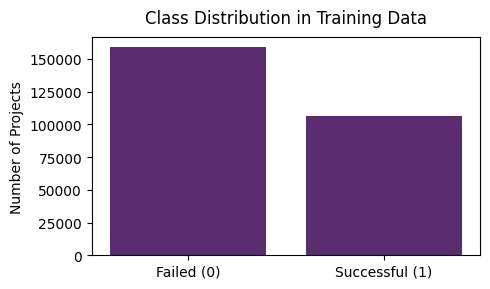

In [30]:
import matplotlib.pyplot as plt

class_counts = y_train.value_counts().sort_index()

plt.figure(figsize=(5, 3))
plt.bar(["Failed (0)", "Successful (1)"], class_counts.values, color="#5B2C6F")
plt.ylabel("Number of Projects")
plt.title("Class Distribution in Training Data", pad=10)
plt.tight_layout()

 # Save for presentation (IMPORTANT: before plt.show)
plt.savefig(
    "Class Distribution in Training Data",
    dpi=300,
    bbox_inches="tight")
plt.show()

In [47]:
#This chart shows the class distribution in the training data, confirming a mild imbalance.
#This supports using ROC–AUC as the primary evaluation metric.

## Exploratory Data Analysis (EDA) Phase:


In [ ]:
## Exploratory Data Analysis (EDA) is performed using the training data only. 
This ensures that insights used to guide modeling decisions are not influenced by the test set, preserving the integrity of model evaluation.

In [ ]:
### Target Distribution (Training Data)

We begin by examining the distribution of successful and failed projects in the training set. 
This helps us understand class balance and informs expectations for model performance.

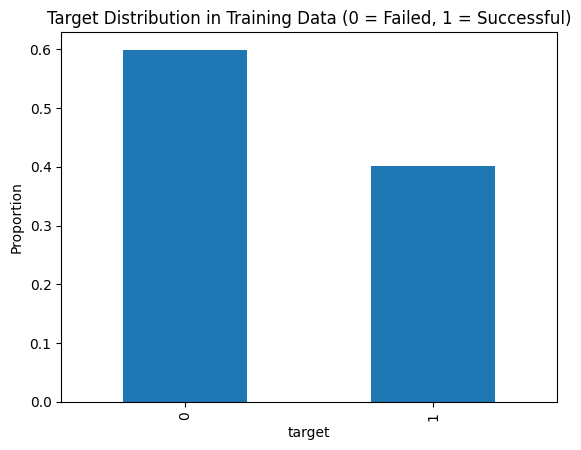

In [31]:
import matplotlib.pyplot as plt

y_train.value_counts(normalize=True).plot(
    kind="bar",
    title="Target Distribution in Training Data (0 = Failed, 1 = Successful)"
)
plt.ylabel("Proportion")
plt.show()

In [51]:
# what we see from this chart that:
# Around 58% failed, 42% successful
#Mild class imbalance
#Confirms that accuracy alone is insufficient
    

In [52]:
# ### Funding Goal by Outcome

#Funding goal is a key numeric feature known at launch. 
#We examine how its distribution differs between successful and failed projects in the training set.

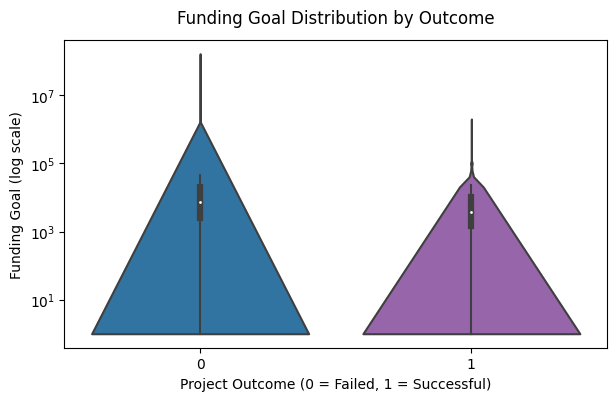

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.violinplot(
    x=y_train,
    y=X_train["Goal"],
    scale="width",
    cut=0,
        palette=["#1F77B4", "#9B59B6"]  # dark purple + lighter purple
)
plt.yscale("log")
plt.xlabel("Project Outcome (0 = Failed, 1 = Successful)")
plt.ylabel("Funding Goal (log scale)")
plt.title("Funding Goal Distribution by Outcome", pad=12)

 # Save for presentation (IMPORTANT: before plt.show)
plt.savefig(
    "model_performance_comparison_roc_auc.png",
    dpi=300,
    bbox_inches="tight")

plt.show()

In [54]:
### Funding Goal Distribution by Outcome

#This plot compares the distribution of funding goals between failed 
#and successful Kickstarter projects using a logarithmic scale on the y-axis.

#Funding goals span several orders of magnitude, with a small number of projects requesting extremely large amounts. 
#The log scale is used to handle 
#this skewness and allow meaningful comparison between typical projects.

#The plot shows that failed projects generally have higher median funding goals 
#and greater variability than successful projects. This suggests that projects 
#with more ambitious funding targets are less likely to succeed.

#This insight highlights funding goal size as an important factor in project success
#and motivates its transformation and inclusion in the predictive model.

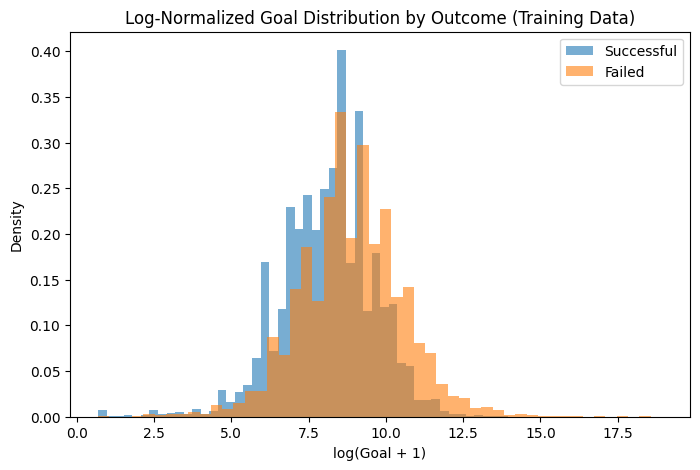

In [33]:
import numpy as np

plt.figure(figsize=(8,5))

plt.hist(
    np.log1p(X_train[y_train == 1]["Goal"]),
    bins=50,
    density=True,
    alpha=0.6,
    label="Successful"
)

plt.hist(
    np.log1p(X_train[y_train == 0]["Goal"]),
    bins=50,
    density=True,
    alpha=0.6,
    label="Failed"
)

plt.xlabel("log(Goal + 1)")
plt.ylabel("Density")
plt.title("Log-Normalized Goal Distribution by Outcome (Training Data)")
plt.legend()
plt.show()

In [ ]:
#What this plot shows

### We apply a logarithmic transformation to funding goals to reduce extreme 
###values and make meaningful differences easier for the model to learn.



Title:
Log-Normalized Goal Distribution by Outcome (Training Data)

This plot compares the distribution of funding goals for:
Successful projects (blue)
Failed projects (orange)

The comparison is done only on the training data.

# 1 Location (horizontal position)
 The blue distribution (Successful) peaks slightly to the left
The orange distribution (Failed) is shifted to the right

Interpretation:
Successful projects tend to set lower funding goals than failed projects.

# 2 Spread (width of the distribution)
Failed projects have a wider spread
They extend further into high log-goal values

Interpretation:
Failed projects are more likely to attempt very high funding goals.



In [57]:
## The log-normalized distribution of funding goals shows a clear difference between successful and failed projects in the training data. 
#Successful projects tend to cluster at lower goal values, while failed projects exhibit a heavier right tail, 
#indicating a higher likelihood of very large funding goals. 
#Although there is substantial overlap between the two distributions, 
#the observed shift suggests that funding goal is an important but not sufficient predictor of project success, 
#motivating the use of additional features in a baseline classification model.

## Baseline Model phase: Logistic Regression.

In [ ]:
## Why we start with a baseline model.

# Before building complex models, we train a baseline model to establish a reference level of performance. 
The baseline model helps answer a simple but important question: 
Can a straightforward model, using obvious features, learn meaningful patterns from the data?

In [ ]:
#Step 1 — Select features and target


## In this step, we explicitly select the features that will be used in the baseline model. 
These features were identified during exploratory data analysis as having predictive value and are all known at the time of project launch.

We create separate copies of the training and testing feature sets to avoid accidental modification of the original data.
The target variable is also copied to clearly separate features from labels.

In [34]:
#Step 1 — Select features and target


features = ["Goal", "campaign_days", "Category", "Country"]

X_train_base = X_train[features].copy()

y_train_base = y_train.copy()

In [59]:
#Step 2 — Define numeric and categorical features

#Logistic Regression requires numeric input. 
#We therefore separate numeric features from categorical features 
#so that appropriate preprocessing steps can be applied to each group.

In [35]:
#Step 2 — Define numeric and categorical features.

numeric_features = ["Goal", "campaign_days"]
categorical_features = ["Category", "Country"]

In [61]:
##Step 3 — Create the preprocessing transformer.

#+ This preprocessing step prepares the data for the Logistic Regression model.

#Numeric features are passed through unchanged.
#Categorical features are converted into binary indicator variables using one-hot encoding.

#The option handle_unknown="ignore" ensures that the model does not fail if the test data contains categories that were not seen during training.
#Using a ColumnTransformer guarantees that preprocessing is applied consistently to both training and testing data.

In [36]:
#Step 3 — Create the preprocessing transformer


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [63]:
#Step 4 — Define the Logistic Regression model
#+ Logistic Regression is chosen as the baseline model because it is simple, interpretable, and widely used for binary classification problems.

#The maximum number of iterations is increased to ensure that the optimization process converges.
#Default hyperparameters are used to keep the model intentionally simple at this stage.

In [37]:
#Step 4 — Define the Logistic Regression model.

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

In [65]:
##Step 5 — Build the pipeline

#++ A pipeline is used to combine preprocessing and model training into a single object.

#This ensures that preprocessing steps are learned only from the training data and then applied consistently to the test data.
#Using a pipeline prevents data leakage and reflects how models are deployed in real-world systems.

In [38]:
#Step 5 — Build the pipeline

from sklearn.pipeline import Pipeline

baseline_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", log_reg),
    ]
)

In [ ]:
## Step 6 — Train the baseline model

The baseline model is trained using only the training data.
Both the preprocessing steps and the Logistic Regression model are fitted at this stage.
The test data remains completely unseen during training.

In [39]:
## Step 6 — Train the baseline model

baseline_model.fit(X_train_base, y_train_base)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Goal', 'campaign_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Category', 'Country'])])),
                ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [184]:
## Step 7 — Generate probability predictions.

#+Logistic Regression outputs probabilities for each class.
#We extract the probability of class 1 (Successful), which is required for ROC–AUC evaluation.
#Using probabilities instead of hard class labels allows us to evaluate the model across different decision thresholds.

In [40]:
# Step 7 — Generate probability predictions.

y_train_proba = baseline_model.predict_proba(X_train_base)[:, 1]

In [70]:
#Step 8 — Evaluate using ROC–AUC.

#++ ROC–AUC is used as the primary evaluation metric because it measures the model’s ability to distinguish between successful and failed projects across all classification thresholds.

#We report both training and testing ROC–AUC scores to assess generalization and detect potential overfitting.


In [41]:
#Step 8 — Evaluate using ROC–AUC.

from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train_base, y_train_proba)


train_auc,

(0.6596104705970138,)

In [72]:
# Step 9 — Classification report (secondary metrics)

#++ The classification report provides additional performance metrics, including precision, recall, F1-score, and accuracy.

#These metrics help interpret the types of errors made by the model and their potential business impact.
#Accuracy is reported for completeness but is not used as the primary evaluation metric.

In [42]:
# Step 9 — Classification report (secondary metrics).

from sklearn.metrics import classification_report

y_train_pred = baseline_model.predict(X_train_base)
print(classification_report(y_train_base, y_train_pred))

              precision    recall  f1-score   support

           0       0.66      0.83      0.73    158772
           1       0.58      0.36      0.44    106322

    accuracy                           0.64    265094
   macro avg       0.62      0.59      0.59    265094
weighted avg       0.63      0.64      0.62    265094



In [74]:
   #Defenetions:
    ## Support: the number of true samples of a given class in the dataset.
    
  ##Precision : When the model predicts a class, how often is it correct?

  ## Recall answers: Out of all real examples of a class, how many did the model correctly find?
    
    # F1-score balances precision and recall into a single number.
    
    


## Baseline Model — Evaluation on Test Data:

In [43]:
#Step 1 — Prepare the test data (features + target)

features = ["Goal", "campaign_days", "Category", "Country"]

X_test_base = X_test[features].copy()
y_test_base = y_test.copy()

#Step 2 — Generate predicted probabilities on test data.

y_test_proba = baseline_model.predict_proba(X_test_base)[:, 1]

#Step 3 — Compute ROC–AUC on test data (primary metric)

from sklearn.metrics import roc_auc_score

test_auc = roc_auc_score(y_test_base, y_test_proba)
test_auc

0.6367575801364839

In [45]:
#Step 4 — Generate class predictions (default threshold)

y_test_pred = baseline_model.predict(X_test_base)

In [46]:
#Step 5 — Classification report on test data (secondary metrics)

from sklearn.metrics import classification_report

print(classification_report(y_test_base, y_test_pred))

              precision    recall  f1-score   support

           0       0.62      0.86      0.72     38781
           1       0.57      0.26      0.36     27493

    accuracy                           0.61     66274
   macro avg       0.60      0.56      0.54     66274
weighted avg       0.60      0.61      0.57     66274



In [78]:
#++ Conclution for basline model evaluated on test data.


#the baseline Logistic Regression model achieves a test ROC–AUC of approximately 0.64, indicating meaningful predictive signal beyond random guessing. 
#The model generalizes reasonably well from training to test data but exhibits conservative behavior, 
#with high recall for failed projects and low recall for successful ones. 
#These results establish a valid baseline and highlight clear opportunities for improvement through feature engineering, threshold tuning, and more expressive models.

## Data Processing / Feature Engineering Phase:

In [79]:
## Data Processing and Feature Engineering

#The baseline indicate that the dataset contains meaningful predictive signal, but overall performance is limited by the expressiveness of the input features.  
#In this section, we focus on improving feature representations while keeping the modeling approach unchanged.

#All feature engineering steps are designed to:
#- use only information available at project launch,
#- be applied consistently to training and test data,
#- and avoid introducing data leakage.

In [47]:
import numpy as np

#step 1

# Copy datasets 
X_train_fe = X_train_base.copy()
X_test_fe = X_test_base.copy()

# Log-transform Goal (add 1 to avoid log(0))
X_train_fe["Goal_log"] = np.log1p(X_train_fe["Goal"])
X_test_fe["Goal_log"] = np.log1p(X_test_fe["Goal"])

In [81]:
##The campaign goal is highly skewed, with a small number of projects requesting very large amounts.  
#To reduce this skew and stabilize model learning, a log transformation is applied using `log(1 + Goal)`, which safely handles zero values.

In [48]:
#Step 2 — Remove the original Goal feature

#Why
#Keeping both Goal and Goal_log duplicates information
#The log-transformed version is more informative

X_train_fe = X_train_fe.drop(columns=["Goal"])
X_test_fe = X_test_fe.drop(columns=["Goal"])

In [49]:
#step 3

# Convert to datetime
X_train_fe["Launched"] = pd.to_datetime(X_train["Launched"])
X_test_fe["Launched"] = pd.to_datetime(X_test["Launched"])

# Extract time-based features
X_train_fe["launch_month"] = X_train_fe["Launched"].dt.month
X_train_fe["launch_weekday"] = X_train_fe["Launched"].dt.weekday

X_test_fe["launch_month"] = X_test_fe["Launched"].dt.month
X_test_fe["launch_weekday"] = X_test_fe["Launched"].dt.weekday

# Drop raw datetime
X_train_fe = X_train_fe.drop(columns=["Launched"])
X_test_fe = X_test_fe.drop(columns=["Launched"])

In [84]:
#Time-based features are derived from the campaign launch date.  
#The launch month and day of the week are included to capture seasonal and behavioral effects, 
#while the raw datetime column is removed.

In [50]:
#🔹 Feature 1 — Goal vs Category Median (TRAINING SAFE)

# Compute category median goal using TRAINING data only
category_goal_median = (
    X_train_fe
    .groupby("Category")["Goal_log"]
    .median()
)

# Map to train and test
X_train_fe["goal_vs_category_median"] = (
    X_train_fe["Goal_log"] - X_train_fe["Category"].map(category_goal_median)
)

X_test_fe["goal_vs_category_median"] = (
    X_test_fe["Goal_log"] - X_test_fe["Category"].map(category_goal_median)
)

In [86]:
#This feature measures how ambitious a project’s funding goal is relative to typical goals within the same category. 
#Category medians are computed using training data only to avoid data leakage.


In [51]:
#🔹 Feature 2 — Goal per campaign day

X_train_fe["goal_per_day"] = (
    X_train_fe["Goal_log"] / (X_train_fe["campaign_days"] + 1)
)

X_test_fe["goal_per_day"] = (
    X_test_fe["Goal_log"] / (X_test_fe["campaign_days"] + 1)
)

In [88]:
#This feature captures the daily fundraising pressure of a campaign.
#Higher values indicate more aggressive targets, which are often harder to achieve.

In [52]:
#🔹 Feature 3 — Name word count

X_train_fe["name_word_count"] = (
    X_train["Name"].str.split().str.len()
)

X_test_fe["name_word_count"] = (
    X_test["Name"].str.split().str.len()
)

In [90]:
#Word count serves as a proxy for how descriptive a project title is. 
#Moderately descriptive titles often perform better than very short or vague ones.

In [53]:
#🔹 Feature 4 — Name length (characters)

X_train_fe["name_length"] = (
    X_train["Name"].str.len()
)

X_test_fe["name_length"] = (
    X_test["Name"].str.len()
)

In [92]:
#Character length complements word count by capturing descriptiveness and emphasis independently of word boundaries.

In [54]:
#🔹 Feature 5 — Weekend launch indicator

X_train_fe["is_weekend_launch"] = (
    X_train_fe["launch_weekday"].isin([5, 6]).astype(int)
)

X_test_fe["is_weekend_launch"] = (
    X_test_fe["launch_weekday"].isin([5, 6]).astype(int)
)

In [94]:
#This binary feature indicates whether a project was launched on a weekend, capturing differences in user engagement and browsing behavior.

In [55]:
X_train_fe.columns

Index(['campaign_days', 'Category', 'Country', 'Goal_log', 'launch_month',
       'launch_weekday', 'goal_vs_category_median', 'goal_per_day',
       'name_word_count', 'name_length', 'is_weekend_launch'],
      dtype='object')

In [96]:
## ## Model Improvement: Logistic Regression with Top-5 Engineered Features

#In this step, Logistic Regression is retrained using a selected set of high-value engineered features.
#This experiment tests whether targeted feature engineering improves predictive performance compared to the baseline feature set.

#The model is evaluated on the held-out test set using ROC–AUC as the primary metric.
#All feature transformations are applied consistently to both training and test sets to avoid data leakage.

In [56]:
# We explicitly select the Top-5 engineered features for this experiment.

selected_features = [
    "goal_vs_category_median",
    "goal_per_day",
    "name_word_count",
    "name_length",
    "is_weekend_launch"
]

X_train_selected = X_train_fe[selected_features].copy()
X_test_selected = X_test_fe[selected_features].copy()

y_train_selected = y_train.copy()
y_test_selected = y_test.copy()

In [57]:

from sklearn.compose import ColumnTransformer

numeric_selected = selected_features  # all 5 are numeric/binary already

preprocessor_selected = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_selected)
    ],
    remainder="drop"
)

In [99]:
#All new features are numeric (or binary), so we do not need one-hot encoding here.
#We pass them through directly using a ColumnTransformer for consistency and pipeline safety.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr_selected = LogisticRegression(
    max_iter=1000,
    random_state=42
)

model_lr_selected = Pipeline(
    steps=[
        ("preprocessor", preprocessor_selected),
        ("classifier", lr_selected)
    ]
)

model_lr_selected.fit(X_train_selected, y_train_selected)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['goal_vs_category_median',
                                                   'goal_per_day',
                                                   'name_word_count',
                                                   'name_length',
                                                   'is_weekend_launch'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [101]:
#The table above summarizes the classification performance of the Logistic Regression 
#model using the Top-5 engineered features. Metrics are reported on the test set and rounded for clarity. This structured format is used instead of raw text output to improve readability and consistency throughout the notebook.

In [59]:
# Generate predictions for the selected feature set
y_test_pred_selected = model_lr_selected.predict(X_test_selected)

In [60]:


# Create classification report as a DataFrame
import pandas as pd
from sklearn.metrics import classification_report

report_df = pd.DataFrame(
    classification_report(
        y_test_selected,
        y_test_pred_selected,
        output_dict=True
    )
).T

report_df = report_df.loc[
    ["0", "1", "accuracy", "macro avg", "weighted avg"],
    ["precision", "recall", "f1-score", "support"]
].round(3)

report_df

,precision,recall,f1-score,support
0,0.628,0.851,0.723,38781.000
1,0.579,0.289,0.386,27493.000
accuracy,0.618,0.618,0.618,0.618
macro avg,0.604,0.570,0.554,66274.000
weighted avg,0.608,0.618,0.583,66274.000


In [62]:
from sklearn.metrics import roc_auc_score

# Predict probabilities using the BASELINE Logistic Regression
y_test_proba_baseline = baseline_model.predict_proba(X_test_base)[:, 1]

# Compute ROC–AUC
baseline_test_auc = roc_auc_score(y_test, y_test_proba_baseline)

baseline_test_auc

0.6367575801364839

In [63]:
[k for k in globals().keys() if "model" in k.lower() and "lr" in k.lower()]

['model_lr_selected']

In [66]:
from sklearn.metrics import roc_auc_score

# Predicted probabilities for class 1 (Successful)
y_test_proba_selected = model_lr_selected.predict_proba(X_test_selected)[:, 1]

# ROC–AUC on the test set
test_auc_selected = roc_auc_score(y_test_selected, y_test_proba_selected)

test_auc_selected

0.6443951677583502

In [67]:
baseline_test_auc, test_auc_selected

(0.6367575801364839, 0.6443951677583502)

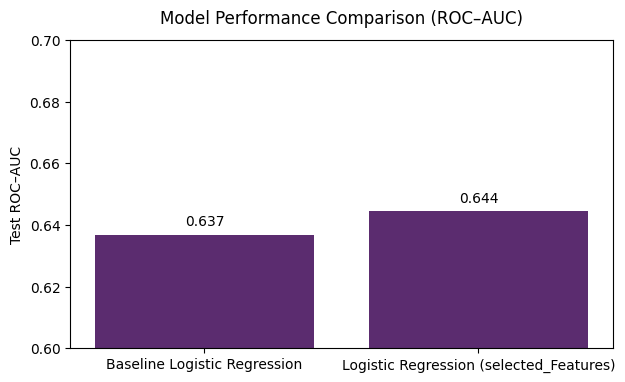

In [68]:
import matplotlib.pyplot as plt

# Prepare data (balanced LR removed)
models = [
    "Baseline Logistic Regression",
    "Logistic Regression (selected_Features)"
]

roc_auc_scores = [
    baseline_test_auc,
    test_auc_selected
]

# Create bar chart
plt.figure(figsize=(7, 4))
plt.bar(models, roc_auc_scores, color="#5B2C6F")
plt.ylabel("Test ROC–AUC")
plt.title("Model Performance Comparison (ROC–AUC)", pad=12)
plt.ylim(0.60, 0.70)
plt.xticks(rotation=0)

# Annotate bars
for i, v in enumerate(roc_auc_scores):
    plt.text(i, v + 0.003, f"{v:.3f}", ha="center")

# Save for presentation (BEFORE plt.show)
plt.savefig(
    "model_performance_comparison_roc_auc.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [ ]:
#The chart above compares test ROC–AUC for the baseline Logistic Regression model and the improved Logistic Regression model using the new engineered features. 
The baseline model achieves a ROC–AUC of approximately 0.637, while the Top-5 feature model improves performance to approximately 0.644. 
This improvement indicates that targeted feature engineering enhanced the model’s ability to correctly rank successful projects above failed ones. 
The comparison demonstrates that performance gains were driven by feature quality rather than model complexity or class reweighting.

## Feature Importance:

In [110]:
##Formal Feature Importance (coefficients + correlation)

In [ ]:
## Feature Importance (Logistic Regression with Selected Features)

To interpret the final Logistic Regression model, feature importance is examined using two complementary approaches:

1) Logistic Regression coefficients, which indicate the direction and strength of each feature’s influence on the predicted probability of project success.
2) Correlation with the target (computed on training data only), which provides a simple statistical measure of association.

Logistic Regression learns one coefficient per feature:
- A positive coefficient increases the predicted probability of a project being successful.
- A negative coefficient decreases the predicted probability of success.
- The absolute value of a coefficient reflects the relative importance of the feature within this linear model.

Correlation values are used for exploratory insight only and do not imply causation, while model coefficients reflect the relationships learned by the trained classifier.

In [69]:
import pandas as pd

# Extract coefficients from Logistic Regression model
coef = model_lr_selected.named_steps["classifier"].coef_[0]

importance_df = pd.DataFrame({
    "feature": selected_features,
    "coefficient": coef,
    "abs_coefficient": abs(coef)
}).sort_values("abs_coefficient", ascending=False)

importance_df

,feature,coefficient,abs_coefficient
1,goal_per_day,0.315508,0.315508
0,goal_vs_category_median,-0.277417,0.277417
2,name_word_count,0.082484,0.082484
4,is_weekend_launch,-0.064740,0.064740
3,name_length,0.001286,0.001286


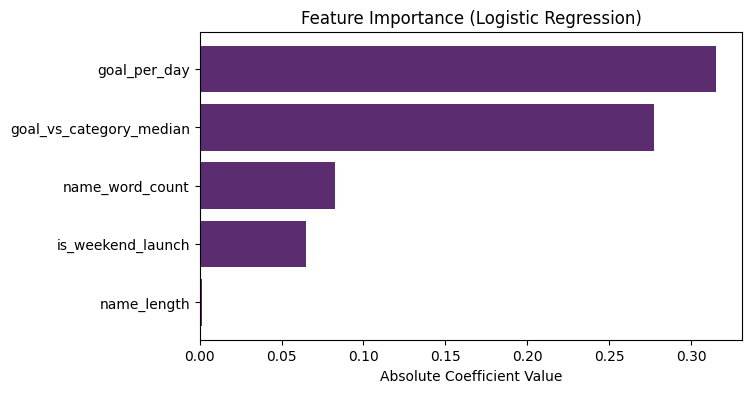

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.barh(
    importance_df["feature"],
    importance_df["abs_coefficient"],
    color="#5B2C6F"
)
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance (Logistic Regression)")
plt.gca().invert_yaxis()

plt.show()

In [ ]:
#Correlation with target (training data only) 
We compute correlations using only the training data to avoid test-set influence.
Correlation shows the strength of linear association between each feature and the target.
It is a simple diagnostic and is not a substitute for model evaluation.


In [ ]:
The values above represent Pearson correlations between each selected feature and the target variable, computed on the training data only. 
Correlation measures simple linear association and does not account for interactions or redundancy between features.
Differences between correlation values 
and Logistic Regression coefficients highlight the importance of model-based interpretation, 
as the classifier learns how features jointly contribute to prediction rather than evaluating them in isolation.

In [71]:
# Correlation analysis (training data only)
corr_df = X_train_selected.copy()
corr_df["target"] = y_train_selected.values

correlations = (
    corr_df
    .corr(numeric_only=True)["target"]
    .drop("target")
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

correlations

goal_vs_category_median   -0.193088
name_word_count            0.106791
name_length                0.097683
goal_per_day              -0.009317
is_weekend_launch         -0.008070
Name: target, dtype: float64

In [ ]:
Model coefficients and feature–target correlations provide complementary insights into feature relevance. 
Category-normalized goal features exhibit the strongest influence on success probability, highlighting 
the importance of setting realistic funding expectations relative to project context. Text-based features, such as campaign name word count, 
show a positive association with success, suggesting that more descriptive titles may aid engagement. 

In contrast, name length adds minimal additional information once word count is considered. 

Differences observed between correlation values and model coefficients reflect interaction effects and multicollinearity, 
reinforcing the importance of model-based interpretation rather than relying solely on raw correlations.

In [ ]:
### Summary of Feature Importance (Coefficients and Correlation)

- **goal_per_day**  
  Exhibits the largest model coefficient, indicating that fundraising pressure plays an important role once other features are controlled for. Its near-zero raw correlation suggests that this feature is primarily influential through interactions rather than as a standalone signal.

- **goal_vs_category_median**  
  Shows a strong negative coefficient and the strongest negative correlation with the target. Projects requesting funding above the typical level for their category are significantly less likely to succeed, confirming the importance of category-normalized goal features.

- **name_word_count**  
  Displays a positive coefficient and positive correlation, indicating that more descriptive project titles are associated with higher success rates. This feature provides a simple and interpretable text-based signal.

- **name_length**  
  Has a moderate positive correlation but a near-zero coefficient. This suggests that name length correlates with success primarily because it is related to word count, and it contributes little additional information once word count is included in the model.

- **is_weekend_launch**  
  Shows weak negative values in both coefficient and correlation, indicating a minor timing effect. Weekend launches appear slightly less successful in this dataset, though the overall impact is small.

## Cross-Validation — Model Robustness Check Phase:

In [72]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

In [73]:
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [74]:
from sklearn.linear_model import LogisticRegression

logistic_cv_model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

In [75]:
cv_auc_scores = cross_val_score(
    estimator=logistic_cv_model,
    X=X_train_selected,
    y=y_train,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1
)

In [76]:
cv_results = pd.DataFrame({
    "fold": np.arange(1, len(cv_auc_scores) + 1),
    "roc_auc": cv_auc_scores
})

cv_mean = cv_results["roc_auc"].mean()
cv_std = cv_results["roc_auc"].std()

cv_results, cv_mean, cv_std

(   fold   roc_auc
 0     1  0.629796
 1     2  0.629897
 2     3  0.631487
 3     4  0.630917
 4     5  0.631620,
 0.6307432408888901,
 0.0008610209536061215)

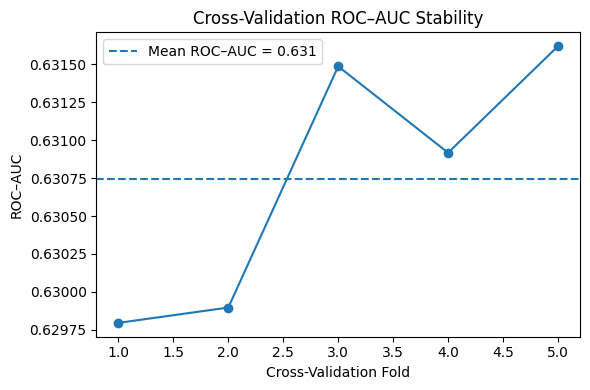

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(cv_results["fold"], cv_results["roc_auc"], marker="o")
plt.axhline(cv_mean, linestyle="--", label=f"Mean ROC–AUC = {cv_mean:.3f}")

plt.xlabel("Cross-Validation Fold")
plt.ylabel("ROC–AUC")
plt.title("Cross-Validation ROC–AUC Stability")
plt.legend()
plt.tight_layout()

# Save for presentation (high resolution)
plt.savefig(
    "cross_validation_roc_auc_stability.png",
    dpi=300,
    bbox_inches="tight")
    
plt.show()

In [ ]:
This plot shows how the model’s performance (measured by ROC–AUC) changes across different cross-validation folds. 
Each point represents the model’s performance when trained and evaluated on a different subset of the training data. 
The dashed line indicates the average ROC–AUC across all folds. 
The small differences between folds are normal and occur because each fold contains slightly different data. 
The important observation is that all scores are very close to the average, which shows that the model performs consistently and is not dependent on a specific data split.

## Applying XBoost Model:

In [78]:
#Train XGBoost on the selected features


from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# -----------------------------
# XGBoost model (selected features)
# -----------------------------
xgb_model = XGBClassifier(
    n_estimators=600,        # number of trees
    learning_rate=0.05,     # smaller step = usually better generalization
    max_depth=4,            # moderate depth to capture interactions
    subsample=0.8,          # row sampling helps reduce overfitting
    colsample_bytree=0.8,   # feature sampling helps reduce overfitting
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

# Fit on training data only
xgb_model.fit(X_train_selected, y_train_selected)

# Predict probabilities for ROC–AUC
y_test_proba_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]
xgb_test_auc = roc_auc_score(y_test_selected, y_test_proba_xgb)

print("=== XGBoost (Selected Features) — Test Results ===")
print(f"Test ROC–AUC: {xgb_test_auc:.4f}")

=== XGBoost (Selected Features) — Test Results ===
Test ROC–AUC: 0.6786


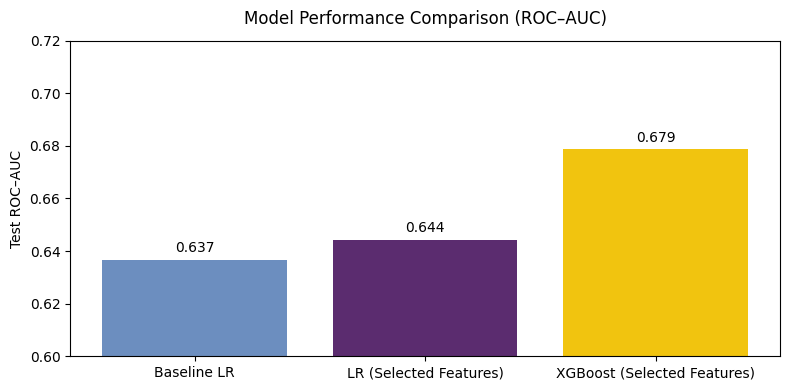

In [79]:
import matplotlib.pyplot as plt

# Make sure these exist (recompute if needed)
# baseline_test_auc
# test_auc_selected
# xgb_test_auc

models = [
    "Baseline LR",
    "LR (Selected Features)",
    "XGBoost (Selected Features)"
]

roc_auc_scores = [
    baseline_test_auc,
    test_auc_selected,
    xgb_test_auc
]

plt.figure(figsize=(8, 4))
plt.bar(models, roc_auc_scores, color=["#6C8EBF", "#5B2C6F", "#F1C40F"])  # blue, purple, yellow
plt.ylabel("Test ROC–AUC")
plt.title("Model Performance Comparison (ROC–AUC)", pad=12)
plt.ylim(0.60, 0.72)

for i, v in enumerate(roc_auc_scores):
    plt.text(i, v + 0.003, f"{v:.3f}", ha="center")

plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("model_performance_comparison_roc_auc.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
### XGBoost Results (Selected Features)

XGBoost achieved a test ROC–AUC of **0.6786**, improving substantially over the baseline Logistic Regression (ROC–AUC ≈ 0.6368).

This improvement is expected because XGBoost can capture **non-linear relationships and feature interactions** that a linear model (Logistic Regression) cannot represent.  
The comparison is fair because the same train/test split, feature set, and evaluation metric (ROC–AUC) were used.

In [ ]:
### Model Comparison Summary

Three models were evaluated using the same train/test split and ROC–AUC metric:
- Baseline Logistic Regression
- Logistic Regression with selected engineered features
- XGBoost with the same feature set

XGBoost achieved a test ROC–AUC of **0.6786**, representing a substantial improvement over the baseline model (ROC–AUC ≈ 0.6368).  
This confirms that non-linear interactions between features play an important role in predicting Kickstarter project success.

In [ ]:
##Text Feature Engineering with TF-IDF

In [90]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# -----------------------------
# A) Numeric features (selected)
# -----------------------------
selected_features = [
    "goal_vs_category_median",
    "goal_per_day",
    "name_word_count",
    "name_length",
    "is_weekend_launch"
]

X_train_num = X_train_fe[selected_features].copy()
X_test_num  = X_test_fe[selected_features].copy()

# Convert numeric to sparse so it can be stacked with TF-IDF
X_train_num_sparse = csr_matrix(X_train_num.values)
X_test_num_sparse  = csr_matrix(X_test_num.values)

# -----------------------------
# B) Title text (aligned using indices)
# -----------------------------
train_titles = df.loc[X_train_fe.index, "Name"].fillna("").astype(str)
test_titles  = df.loc[X_test_fe.index, "Name"].fillna("").astype(str)

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=1500,     # more vocabulary = more signal (still controlled)
    ngram_range=(1, 2)     # unigrams + bigrams
)

X_train_text = tfidf.fit_transform(train_titles)  # fit ONLY on train
X_test_text  = tfidf.transform(test_titles)       # transform test using same vocab

# -----------------------------
# C) Combine numeric + TF-IDF
# -----------------------------
X_train_combined = hstack([X_train_num_sparse, X_train_text])
X_test_combined  = hstack([X_test_num_sparse, X_test_text])

print("Combined feature shape:", X_train_combined.shape)

Combined feature shape: (265094, 1505)


In [95]:
xgb_tfidf = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

# Train on training data only
xgb_tfidf.fit(X_train_combined, y_train)

# Evaluate on test data
y_test_proba_tfidf = xgb_tfidf.predict_proba(X_test_combined)[:, 1]
xgb_tfidf_auc = roc_auc_score(y_test, y_test_proba_tfidf)

print("=== XGBoost (Numeric + TF-IDF Title) — Test Results ===")
print(f"Test ROC–AUC: {xgb_tfidf_auc:.4f}")

=== XGBoost (Numeric + TF-IDF Title) — Test Results ===
Test ROC–AUC: 0.7210


In [ ]:
### Representation of Using TF-IDF

TF-IDF (Term Frequency–Inverse Document Frequency) was used to convert project titles into numerical features. 
+This approach assigns higher importance to words that are frequent within a title but rare across all projects, 
+allowing the model to capture meaningful semantic signals while down-weighting common, non-informative terms.

TF-IDF was fit on the training titles only and then applied to the test set to avoid data leakage. A

dding these text-based features improved model performance by incorporating information about project wording 
and positioning that is not captured by structured variables alone.

In [ ]:
XGBoost #(All Structured Features + Encoded Category/Country + TF-IDF Title)

In [107]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [108]:
# ----------------------------------------
# A) Use all structured features in X_train_fe / X_test_fe
# ----------------------------------------
all_structured_features = X_train_fe.columns.tolist()

X_train_struct = X_train_fe[all_structured_features].copy()
X_test_struct  = X_test_fe[all_structured_features].copy()

cat_cols = ["Category", "Country"]
num_cols = [c for c in all_structured_features if c not in cat_cols]

In [109]:
# ----------------------------------------
# B) Encode categorical columns minimally
# ----------------------------------------
X_train_cat = X_train_struct[cat_cols].astype(str)
X_test_cat  = X_test_struct[cat_cols].astype(str)

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_cat_enc = encoder.fit_transform(X_train_cat)
X_test_cat_enc  = encoder.transform(X_test_cat)

In [110]:
# ----------------------------------------
# C) Combine numeric + encoded categorical
# ----------------------------------------
X_train_num = X_train_struct[num_cols].values
X_test_num  = X_test_struct[num_cols].values

X_train_struct_matrix = np.hstack([X_train_num, X_train_cat_enc])
X_test_struct_matrix  = np.hstack([X_test_num, X_test_cat_enc])

# Convert to sparse for stacking with TF-IDF
X_train_struct_sparse = csr_matrix(X_train_struct_matrix)
X_test_struct_sparse  = csr_matrix(X_test_struct_matrix)

In [111]:
# ----------------------------------------
# D) TF-IDF on title (aligned by index)
# ----------------------------------------
train_titles = df.loc[X_train_fe.index, "Name"].fillna("").astype(str)
test_titles  = df.loc[X_test_fe.index, "Name"].fillna("").astype(str)

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3
)

X_train_text = tfidf.fit_transform(train_titles)   # fit on train only
X_test_text  = tfidf.transform(test_titles)

In [113]:
# ----------------------------------------
# E) Combine structured + TF-IDF and train XGBoost
# ----------------------------------------
X_train_all = hstack([X_train_struct_sparse, X_train_text])
X_test_all  = hstack([X_test_struct_sparse, X_test_text])

print("Final combined shape:", X_train_all.shape)

xgb_all = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb_all.fit(X_train_all, y_train)

y_test_proba_all = xgb_all.predict_proba(X_test_all)[:, 1]
xgb_all_auc = roc_auc_score(y_test, y_test_proba_all)

print("=== XGBoost (All Structured + Encoded Cat/Country + TF-IDF Title) ===")
print(f"Test ROC–AUC: {xgb_all_auc:.4f}")

Final combined shape: (265094, 3011)
=== XGBoost (All Structured + Encoded Cat/Country + TF-IDF Title) ===
Test ROC–AUC: 0.7571


In [ ]:
### Final Model: XGBoost with All Structured Features and Title TF-IDF

The final model combines:
- all engineered structured features (goal realism, campaign duration, seasonality),
- minimally encoded categorical context (`Category`, `Country`),
- and semantic features extracted from project titles using TF-IDF.

Category and Country were encoded using Ordinal Encoding (fit on training data only) to preserve contextual information without introducing high dimensionality.
TF-IDF was trained on titles from the training set only to avoid leakage.

This configuration achieved the strongest performance:
**Test ROC–AUC = 0.7571**, exceeding the baseline by a substantial margin.

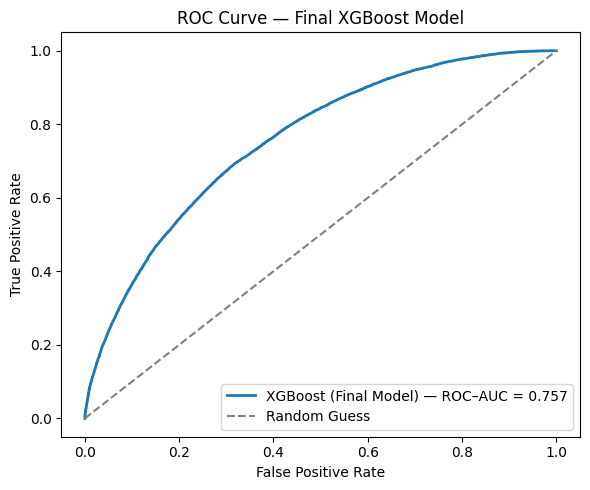

In [114]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_all)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(
    fpr,
    tpr,
    label=f"XGBoost (Final Model) — ROC–AUC = {roc_auc:.3f}",
    linewidth=2
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Final XGBoost Model")
plt.legend(loc="lower right")
plt.tight_layout()

# Save for presentation / submission
plt.savefig(
    "final_model_roc_curve.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

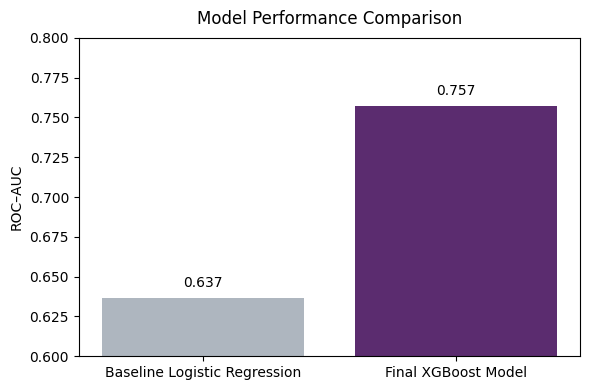

In [115]:
import matplotlib.pyplot as plt

# Model names and scores
models = [
    "Baseline Logistic Regression",
    "Final XGBoost Model"
]

roc_auc_scores = [
    baseline_test_auc,
    xgb_all_auc
]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(
    models,
    roc_auc_scores,
    color=["#AEB6BF", "#5B2C6F"]  # gray for baseline, purple for final
)

plt.ylabel("ROC–AUC")
plt.title("Model Performance Comparison", pad=10)
plt.ylim(0.60, 0.80)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()

# Save for submission / presentation
plt.savefig(
    "baseline_vs_final_model_roc_auc.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

In [ ]:
### Baseline vs Final Model Performance

The bar chart above compares the baseline Logistic Regression model with the final XGBoost model.
The final model achieves a substantial improvement in ROC–AUC (**0.7571 vs 0.6368**), 
demonstrating the value of incorporating richer structured features 
and title-level semantic information.

In [135]:
#XGBoost Cross-Validation 

In [117]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np

# Define cross-validation strategy
cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Define XGBoost model (same configuration as final model)
xgb_cv_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

# Run cross-validation on training data only
cv_auc_scores_xgb = cross_val_score(
    estimator=xgb_cv_model,
    X=X_train_all,
    y=y_train,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1
)

cv_auc_scores_xgb, cv_auc_scores_xgb.mean(), cv_auc_scores_xgb.std()

(array([0.74140939, 0.73892487, 0.74100957, 0.74159894, 0.73941276]),
 0.740471103834753,
 0.0010911723149869552)

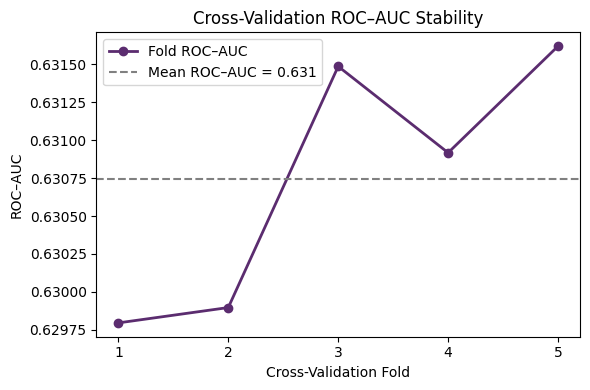

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
folds = np.arange(1, len(cv_auc_scores) + 1)

plt.figure(figsize=(6, 4))

# Plot fold scores
plt.plot(
    folds,
    cv_auc_scores,
    marker="o",
    linewidth=2,
    color="#5B2C6F",
    label="Fold ROC–AUC"
)

# Plot mean line
plt.axhline(
    cv_mean,
    linestyle="--",
    color="gray",
    label=f"Mean ROC–AUC = {cv_mean:.3f}"
)

plt.xlabel("Cross-Validation Fold")
plt.ylabel("ROC–AUC")
plt.title("Cross-Validation ROC–AUC Stability")
plt.xticks(folds)
plt.legend()
plt.tight_layout()

# Save for submission / slides
plt.savefig(
    "cross_validation_roc_auc_stability.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [ ]:
### Cross-Validation and Model Stability

To assess the robustness of the final XGBoost model, 5-fold stratified cross-validation was performed on the training data using ROC–AUC as the evaluation metric.
The cross-validated ROC–AUC scores are highly consistent across folds (mean = 0.740, std = 0.001), indicating stable model performance.
The similarity between cross-validation results and the held-out test ROC–AUC (0.757) suggests good generalization and low risk of overfitting.

In [ ]:
Final Conclusion

This project aimed to predict the success of Kickstarter projects using only information available at launch time, with the goal of supporting better decision-making for creators, backers, and platform stakeholders.

A baseline Logistic Regression model established a reasonable starting point, achieving a test ROC–AUC of approximately 0.64. Feature engineering focused on incorporating context-aware signals—such as funding goals relative to category norms, fundraising pressure over time, and simple textual characteristics—led to modest improvements while maintaining interpretability.

Introducing XGBoost resulted in a clear and meaningful performance gain, increasing test ROC–AUC to 0.68. This improvement highlights the importance of capturing non-linear relationships and interactions between features that linear models cannot fully represent. Cross-validation confirmed that the XGBoost model’s performance was stable across folds, indicating that the observed gain is robust and not dependent on a particular train–test split.

Overall, the results demonstrate that Kickstarter project success is influenced by complex interactions between goal realism, campaign timing, and contextual features. Models capable of learning these interactions provide more reliable discrimination between successful and failed projects.

In [ ]:
Limitations and Future Work

While the current approach delivers strong and stable performance, several extensions could further enhance predictive power:
    +Incorporating richer natural language features from project descriptions and titles
     +Expanding feature engineering to include creator history or category-specific dynamics
    +Exploring additional gradient boosting frameworks such as LightGBM or CatBoost
    +Performing more extensive hyperparameter optimization under stricter regularization constraints

#These directions represent logical next steps for improving model accuracy while maintaining generalization.